In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [16]:
# Get a list of column names and types
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
 # Get a list of column names and types
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


## Bonus Challenge Assignment: Temperature Analysis II

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
calc_temps('2012-02-28', '2013-02-28')

[(54.0, 72.23704268292683, 86.0)]

In [34]:
minv = df.tmin[0]
maxv = df.tmax[0]

In [40]:
yerr = np.std([minv, maxv])

In [41]:
df[1:2]

,tmin,tavg,tmax


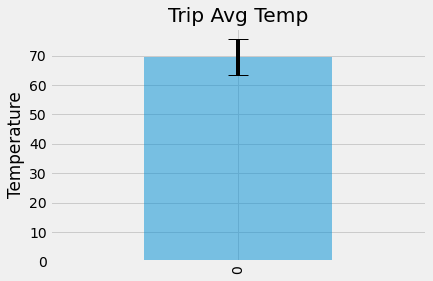

In [44]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

df = pd.DataFrame(calc_temps('2012-02-28', '2012-03-05'), columns=['tmin', 'tavg', 'tmax'])                                   
df['tavg'].plot.bar(yerr=yerr, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature')
plt.show()

### Daily Rainfall Average

In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start_date = '2012-12-15'
trip_end_date = '2012-12-30'
session = Session(engine)
prcp = session.query(func.sum(Measurement.prcp)).\
    filter(Measurement.date.between(trip_start_date, trip_end_date)).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
station =  session.query(Station.station, Station.name, Station.latitude, Station.longitude)

In [50]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates


# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session